# Tutorial - Bayesian Networks Inference in pgmpy

In [ ]:
!pip install pgmpy
from IPython.display import Image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 35.4 MB/s eta 0:00:00


## Bayesian Models
1. What are Bayesian Networks
2. Independencies in Bayesian Networks
3. How is Bayesian Model encoding the Joint Distribution
4. How we do inference from Bayesian models
5. Types of methods for inference

### 1. What are Bayesian Networks
A _Bayesian network_ (Bayes network, belief network, Bayes(ian) model or probabilistic directed acyclic graphical model) is a probabilistic graphical model (a type of statistical model) that represents a set of random variables and their conditional dependencies via a directed acyclic graph (DAG). Bayesian networks are mostly used when we want to represent causal relationship between the random variables. Bayesian Networks are parameterized using Conditional Probability Distributions (CPD). Each node in the network is parameterized using $P(X_i | \text{Parent}(i))$ where $\text{Parent}(i)$ represents the parents of node $X_i$ in the network.

We can take the example of the student model where we consider a course with variable difficulty ($D$). This obviously affects a student's grade ($G$). The grade ($G$) however depends as well on the intelligence ($I$) of the student. Intelligence ($I$) influences as well the SAT score ($S$).

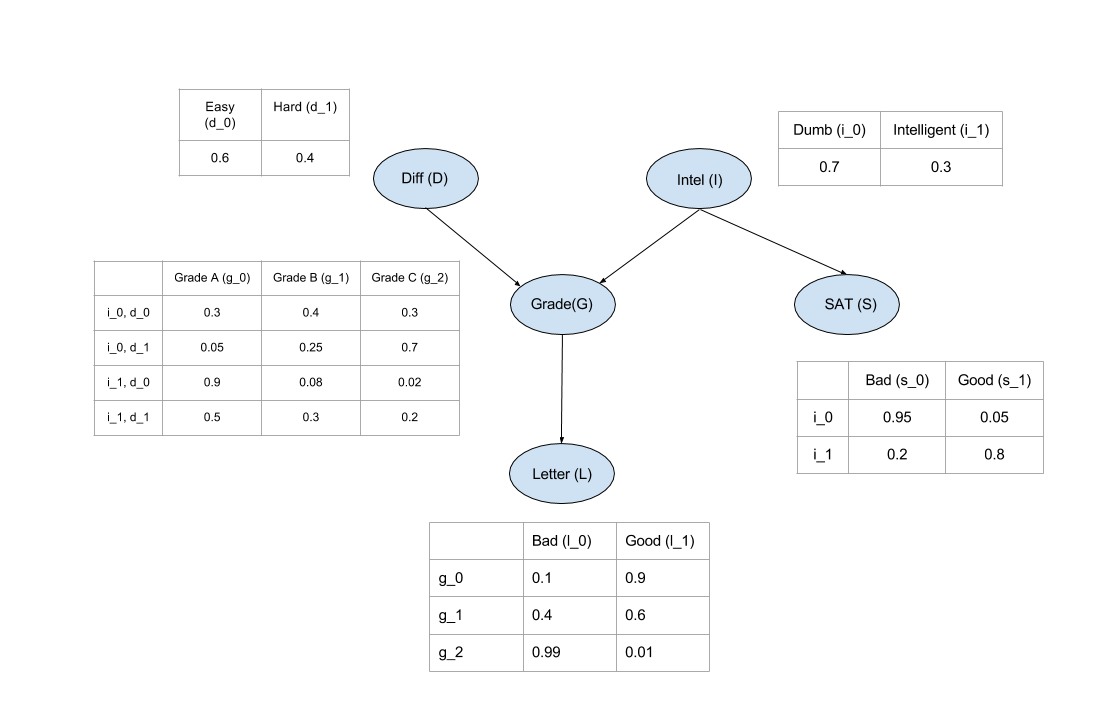

In [ ]:
Image('./Data/student_full_param.png')

In `pgmpy` we define the network structure and the CPDs separately and then associate them with the structure. Here's an example for defining the above model:

In [ ]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.factors.discrete import TabularCPD

# Defining the model structure. We can define the network by just passing a list of edges.
model = DiscreteBayesianNetwork([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Defining individual CPDs.
cpd_d = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]])
cpd_i = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]])

print(cpd_d)
print(cpd_i)

+------+-----+
| D(0) | 0.6 |
+------+-----+
| D(1) | 0.4 |
+------+-----+
+------+-----+
| I(0) | 0.7 |
+------+-----+
| I(1) | 0.3 |
+------+-----+


- `TabularCPD` defines the conditional probability distribution table (CPD table)

- `variable` (int, string (any hashable python object)): The variable whose CPD is defined.
- `variable_card` (integer):  Cardinality/no. of states of variable

- `values` (2D array, 2D list or 2D tuple):  Values for the CPD table.  
       
The representation of CPD in `pgmpy` is a bit different than the CPD shown in the above picture. In `pgmpy` the colums are the __evidences__ and rows are the __states__ of the variable. So the grade CPD is represented like this:       

In [ ]:
cpd_g = TabularCPD(variable='G', variable_card=3,
                   values=[[0.3, 0.05, 0.9,  0.5],
                           [0.4, 0.25, 0.08, 0.3],
                           [0.3, 0.7,  0.02, 0.2]],
                  evidence=['I', 'D'],
                  evidence_card=[2, 2])
print(cpd_g)

+------+------+------+------+------+
| I    | I(0) | I(0) | I(1) | I(1) |
+------+------+------+------+------+
| D    | D(0) | D(1) | D(0) | D(1) |
+------+------+------+------+------+
| G(0) | 0.3  | 0.05 | 0.9  | 0.5  |
+------+------+------+------+------+
| G(1) | 0.4  | 0.25 | 0.08 | 0.3  |
+------+------+------+------+------+
| G(2) | 0.3  | 0.7  | 0.02 | 0.2  |
+------+------+------+------+------+


- `evidence` (array-like): List of variables in evidences(if any) w.r.t. which CPD is defined.

- `evidence_card` (array-like): cardinality/no. of states of variables in `evidence`(if any)

In [ ]:
cpd_l = TabularCPD(variable='L', variable_card=2,
                   values=[[0.1, 0.4, 0.99],
                           [0.9, 0.6, 0.01]],
                   evidence=['G'],
                   evidence_card=[3])
print(cpd_l)

+------+------+------+------+
| G    | G(0) | G(1) | G(2) |
+------+------+------+------+
| L(0) | 0.1  | 0.4  | 0.99 |
+------+------+------+------+
| L(1) | 0.9  | 0.6  | 0.01 |
+------+------+------+------+


In [ ]:
cpd_s = TabularCPD(variable='S', variable_card=2,
                   values=[[0.95, 0.2],
                           [0.05, 0.8]],
                   evidence=['I'],
                   evidence_card=[2])
print(cpd_s)

+------+------+------+
| I    | I(0) | I(1) |
+------+------+------+
| S(0) | 0.95 | 0.2  |
+------+------+------+
| S(1) | 0.05 | 0.8  |
+------+------+------+


In [ ]:
# Associating the CPDs with the network
model.add_cpds(cpd_d, cpd_i, cpd_g, cpd_l, cpd_s)

- `model.add_cpds` adds CPD (Conditional Probability Distribution) to the Bayesian Model.

- `cpds` (list, set, tuple (array-like)): List of CPDs which will be associated with the model

In [ ]:
# check_model checks for the network structure and CPDs and verifies that the CPDs are correctly
# defined and sum to 1.
model.check_model()

True

- `check_model()`: checks the model for various errors.

- checks if the sum of the probabilities for each state is equal to 1 (tol=0.01).

- checks if the CPDs associated with nodes are consistent with their parents.

CPDs can also be defined using the state names of the variables. If the state names are not provided
like in the previous example, `pgmpy` will automatically assign names as: 0, 1, 2, ....


In [ ]:
cpd_d_sn = TabularCPD(variable='D', variable_card=2, values=[[0.6], [0.4]], state_names={'D': ['Easy', 'Hard']})
cpd_i_sn = TabularCPD(variable='I', variable_card=2, values=[[0.7], [0.3]], state_names={'I': ['Dumb', 'Intelligent']})
cpd_g_sn = TabularCPD(variable='G', variable_card=3,
                      values=[[0.3, 0.05, 0.9,  0.5],
                              [0.4, 0.25, 0.08, 0.3],
                              [0.3, 0.7,  0.02, 0.2]],
                      evidence=['I', 'D'],
                      evidence_card=[2, 2],
                      state_names={'G': ['A', 'B', 'C'],
                                   'I': ['Dumb', 'Intelligent'],
                                   'D': ['Easy', 'Hard']})

cpd_l_sn = TabularCPD(variable='L', variable_card=2,
                      values=[[0.1, 0.4, 0.99],
                              [0.9, 0.6, 0.01]],
                      evidence=['G'],
                      evidence_card=[3],
                      state_names={'L': ['Bad', 'Good'],
                                   'G': ['A', 'B', 'C']})

cpd_s_sn = TabularCPD(variable='S', variable_card=2,
                      values=[[0.95, 0.2],
                              [0.05, 0.8]],
                      evidence=['I'],
                      evidence_card=[2],
                      state_names={'S': ['Bad', 'Good'],
                                   'I': ['Dumb', 'Intelligent']})

# These defined CPDs can be added to the model. Since, the model already has CPDs associated to variables, it will
# show warning that pmgpy is now replacing those CPDs with the new ones.
model.add_cpds(cpd_d_sn, cpd_i_sn, cpd_g_sn, cpd_l_sn, cpd_s_sn)
model.check_model()

True

- `state_names` (dict (optional)) – A dict indicating, for each variable, the discrete set of states that the variable can take. If unspecified, the observed values in the data set are taken to be the only possible states.

We can now call some methods on the `BayesianModel` object.

In [ ]:
model.get_cpds()

[<TabularCPD representing P(D:2) at 0x7a2047d335c0>,
 <TabularCPD representing P(I:2) at 0x7a1f485af7d0>,
 <TabularCPD representing P(G:3 | I:2, D:2) at 0x7a1f4c1536e0>,
 <TabularCPD representing P(L:2 | G:3) at 0x7a1f48329790>,
 <TabularCPD representing P(S:2 | I:2) at 0x7a1f4cc41af0>]

- `get_cpds(node=None)` returns the `cpd` of the node. If node is not specified returns all the CPDs that have been added till now to the graph

- `node` (any hashable python object (optional)) – The node whose CPD we want. If node not specified returns all the CPDs added to the model.

- returns: a list of `TabularCPDs`

In [ ]:
# Printing a CPD with it's state names defined.
print(model.get_cpds('G'))

+------+---------+---------+----------------+----------------+
| I    | I(Dumb) | I(Dumb) | I(Intelligent) | I(Intelligent) |
+------+---------+---------+----------------+----------------+
| D    | D(Easy) | D(Hard) | D(Easy)        | D(Hard)        |
+------+---------+---------+----------------+----------------+
| G(A) | 0.3     | 0.05    | 0.9            | 0.5            |
+------+---------+---------+----------------+----------------+
| G(B) | 0.4     | 0.25    | 0.08           | 0.3            |
+------+---------+---------+----------------+----------------+
| G(C) | 0.3     | 0.7     | 0.02           | 0.2            |
+------+---------+---------+----------------+----------------+


In [ ]:
model.get_cardinality('G')

np.int64(3)

- `get_cardinality(node=None)` returns the cardinality of the node. Throws an error if the CPD for the queried node hasn’t been added to the network.

- `node` (Any hashable python object(optional).) – The node whose cardinality we want. If node is not specified returns a dictionary with the given variable as keys and their respective cardinality as values.

### 2. Independencies in Bayesian Networks



In the above two cases it is fairly obvious that change in any of the node will affect the other. For the first case we can take the example of $difficulty \rightarrow grade$. If we increase the difficulty of the course the probability of getting a higher grade decreases. For the second case we can take the example of $SAT \leftarrow Intel$. Now if we increase the probability of getting a good score in SAT that would imply that the student is intelligent, hence increasing the probability of $i_1$. Therefore in both the cases shown above any change in the variables leads to change in the other variable.

In [ ]:
# Getting the local independencies of a variable.
model.local_independencies('G')

(G ⟂ S | I, D)

In [ ]:
# Getting all the local independencies in the network.
model.local_independencies(['D', 'I', 'S', 'G', 'L'])

(D ⟂ I, S)
(I ⟂ D)
(S ⟂ G, L, D | I)
(G ⟂ S | I, D)
(L ⟂ I, S, D | G)

__Active trail__: For any two variables $A$ and $B$ in a network if any change in $A$ influences the values of $B$ then we say that there is an _active trail_ between $A$ and $B$.
In `pgmpy` `active_trail_nodes` gives a set of nodes which are affected (i.e. correlated) by any
change in the node passed in the argument.

In [ ]:
model.active_trail_nodes('D')

{'D': {'D', 'G', 'L'}}

In [ ]:
model.active_trail_nodes('D', observed='G')

{'D': {'D', 'I', 'S'}}

- `observed` (List of nodes (optional)): If given the active trail would be computed assuming these nodes to be observed.

### 3. How is this Bayesian Network representing the Joint Distribution over the variables ?
Till now we just have been considering that the Bayesian Network can represent the Joint Distribution without any proof. Now let's see how to compute the Joint Distribution from the Bayesian Network.

From the chain rule of probabiliy we know that:

$P(A, B) = P(A | B) * P(B)$

Now in this case:

$P(D, I, G, L, S) = P(L| S, G, D, I) * P(S | G, D, I) * P(G | D, I) * P(D | I) * P(I)$

Applying the local independence conditions in the above equation we will get:

$P(D, I, G, L, S) = P(L|G) * P(S|I) * P(G| D, I) * P(D) * P(I)$

From the above equation we can clearly see that the Joint Distribution over all the variables is just the product of all the CPDs in the network. Hence encoding the independencies in the Joint Distribution in a graph structure helped us in reducing the number of parameters that we need to store.

### 4. Inference in Bayesian Models
Till now we discussed just about representing Bayesian Networks. Now let's see how we can do inference in a Bayesian Model and use it to predict values over new data points for machine learning tasks. In this section we will consider that we already have our model. We will talk about constructing the models from data in later parts of this tutorial.

In inference we try to answer probability queries over the network given some other variables. So, we might want to know the probable grade of an intelligent student in a difficult class given that he scored good in SAT. So for computing these values from a Joint Distribution we will have to reduce over the given variables that is $I = 1$, $D = 1$, $S = 1$ and then marginalize over the other variables that is $L$ to get $P(G | I=1, D=1, S=1)$.
But carrying on marginalize and reduce operation on the complete Joint Distribution is computationaly expensive since we need to iterate over the whole table for each operation and the table is exponential is size to the number of variables. But in Graphical Models we exploit the independencies to break these operations in smaller parts making it much faster.

One of the very basic methods of inference in Graphical Models is __Variable Elimination__.

#### Variable Elimination
We know that:

$\mathbb{P}(D, I, G, L, S) = P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now let's say we just want to compute the probability of G. For that we will need to marginalize over all the other variables.

$P(G) = \sum_{D, I, L, S} P(D, I, G, L, S)$

$P(G) = \sum_{D, I, L, S} P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

Now since not all the conditional distributions depend on all the variables we can push the summations inside:

$P(G) = \sum_D \sum_I \sum_L \sum_S P(L|G) * P(S|I) * P(G|D, I) * P(D) * P(I)$

$P(G) = \sum_D P(D) \sum_I P(G|D, I) * P(I) \sum_S P(S|I) \sum_L P(L|G)$

$P(G) =  \sum_I P(G|D, I) * P(I) $



So, by pushing the summations inside we have saved a lot of computation because we have now to iterate over much smaller tables.

Let's take an example for inference using _Variable Elimination_ in `pgmpy`:

In [ ]:
from pgmpy.inference import VariableElimination
infer = VariableElimination(model)
g_dist = infer.query(['G'])
print(g_dist)

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.3620 |
+------+----------+
| G(B) |   0.2884 |
+------+----------+
| G(C) |   0.3496 |
+------+----------+


There can be cases in which we want to compute the conditional distribution let's say $P(G | D=0, I=1)$. In such cases we need to modify our equations a bit:

$P(G | D=0, I=1) = \sum_L \sum_S P(L|G) * P(S| I=1) * P(G| D=0, I=1) * P(D=0) * P(I=1)$

$P(G | D=0, I=1) = P(D=0) * P(I=1) * P(G | D=0, I=1) * \sum_L P(L | G) * \sum_S P(S | I=1)$

In `pgmpy` we will just need to pass an extra argument in the case of conditional distributions:

In [ ]:
print(infer.query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'}))

+------+----------+
| G    |   phi(G) |
+======+==========+
| G(A) |   0.9000 |
+------+----------+
| G(B) |   0.0800 |
+------+----------+
| G(C) |   0.0200 |
+------+----------+


####  Predicting values from new data points
Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. Here's an example:

In [ ]:
infer.map_query(['G'])

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

{'G': 'A'}

In [ ]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'A'}

In [ ]:
infer.map_query(['G'], evidence={'D': 'Easy', 'I': 'Intelligent', 'L': 'Good', 'S': 'Good'})

0it [00:00, ?it/s]

0it [00:00, ?it/s]

{'G': 'A'}

### 5. Other methods for Inference
Even though exact inference algorithms like Variable Elimination optimize the inference task, it is still computationally quite expensive in the case of large models. For such cases we can use approximate algorithms like Message Passing Algorithms, Sampling Algorithms etc. We will talk about a few other exact and approximate algorithms in later parts of the tutorial.